# Evaluación de modelos candidatos

[Carga y preparación datos train y test](#Carga-y-preparación-datos-train-y-test)

[Recuperación de modelos de mlflow](#Recuperación-de-modelos-de-mlflow)

**Análisis**
* [Análisis balanced_accuracy](#Análisis-balanced_accuracy)
* [Análisis especificidad y sensibilidad](#Análisis-especificidad-y-sensibilidad)
* [Análisis por segmentos (géneros literarios)](#Análisis-por-segmentos-(géneros-literarios))
* [Análisis de las variables de cada modelo](#Análisis-de-las-variables-de-cada-modelo)

## Carga y preparación datos train y test

**Carga datos**

In [18]:
import pandas as pd

In [19]:
import os
import sys

# Añadimos la carpeta 'drive' al path
ruta_carpeta_drive = os.path.abspath('../drive')
if ruta_carpeta_drive not in sys.path:
    sys.path.insert(0, ruta_carpeta_drive)

import drive

In [20]:
# Descargamos los datos en formato parquet de Google Drive
drive.descargar_archivos_concretos('datosEntrenamiento.parquet', '../drive')

Archivo datosEntrenamiento.parquet guardado en: ../data/clean\datosEntrenamiento.parquet


In [21]:
data = pd.read_parquet('../data/clean/datosEntrenamiento.parquet')

In [22]:
data.head()

,Bestseller,NumPages,SagaNumber,RedPerc,BluePerc,BelongsSaga,Price,WordsTitle,PriceFormat,BookInterest1M,...,World History,World War I,World War II,Writing,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,Young Adult Science Fiction,Zombies
0,0.0,329.0,1.0,0.51,0.40,0,19.99,1.0,paperback,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,269.0,2.0,0.61,0.54,1,3.99,2.0,ebook,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,2335.0,1.0,0.72,0.57,1,20.99,7.0,ebook,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,40.0,1.0,0.83,0.35,0,25.00,1.0,hardcover,0.0,...,0,0,0,0,1,0,0,0,0,0
4,0.0,189.0,1.0,0.59,0.26,0,15.00,4.0,paperback,0.0,...,0,0,0,0,0,0,0,0,0,0


**Separación train y test**

In [23]:
# Semilla
SEED = 22

# Proporción del conjunto de test
TEST_SIZE = 0.3

Separamos el conjunto de datos sin escalar en train y test

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X = data.drop('Bestseller', axis=1)
y = data['Bestseller']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=SEED)

In [26]:
X_test.head()

,NumPages,SagaNumber,RedPerc,BluePerc,BelongsSaga,Price,WordsTitle,PriceFormat,BookInterest1M,Rating20Days,...,World History,World War I,World War II,Writing,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,Young Adult Science Fiction,Zombies
2720,300.0,2.0,0.49,0.28,1,19.79,4.0,ebook,100.0,4.25,...,0,0,0,0,0,0,0,0,0,0
2496,304.0,1.0,0.72,0.15,0,17.99,2.0,hardcover,0.0,4.26,...,0,0,0,0,1,0,0,0,0,0
2519,128.0,1.0,0.98,0.54,0,16.00,1.0,paperback,793.0,3.82,...,0,0,0,0,0,0,0,0,0,0
3352,336.0,1.0,0.52,0.56,0,14.79,5.0,paperback,100.0,4.06,...,0,0,0,0,0,0,0,0,0,0
2182,336.0,1.0,0.38,0.30,0,24.70,3.0,hardcover,0.0,3.94,...,0,0,0,0,1,0,0,0,0,0


### Escalado de variables
Escalamos las variables y dividimos en train y test

In [27]:
from sklearn.preprocessing import RobustScaler

In [28]:
data_scaled = data.copy()
X_scaled = data_scaled.drop('Bestseller', axis=1)
y_scaled = data_scaled['Bestseller']

# Dividimos en train y test
X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(X_scaled, y_scaled, test_size=TEST_SIZE, stratify=y, random_state=SEED)

# Inicializamos RobustScaler
scaler = RobustScaler()

# Solo lo aplicamos a las variables numéricas
# Incluimos 'Zombies' que no hay que escalar porque el RobustScaler ignora la primera columna de la lista 
# (hemos hecho pruebas)
variables_numericas = ['Zombies', 'SagaNumber', 'NumPages', 'RedPerc', 'BluePerc', 'Price', 'WordsTitle', 'BookInterest1M',
                     'Rating20Days', 'PrevBestSellAuthor']

# Aplicamos el RobustScaler a los datos de entrenamiento y test
X_scaled_train[variables_numericas] = scaler.fit_transform(X_scaled_train[variables_numericas])
X_scaled_test[variables_numericas] = scaler.transform(X_scaled_test[variables_numericas])

In [29]:
X_scaled_test.head()

,NumPages,SagaNumber,RedPerc,BluePerc,BelongsSaga,Price,WordsTitle,PriceFormat,BookInterest1M,Rating20Days,...,World History,World War I,World War II,Writing,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,Young Adult Science Fiction,Zombies
2720,-0.531250,1.0,0.078947,-0.37500,1,0.391026,0.5,ebook,0.000000,0.20,...,0,0,0,0,0,0,0,0,0,0.0
2496,-0.489583,0.0,0.684211,-0.78125,0,0.102564,-0.5,hardcover,-0.555556,0.22,...,0,0,0,0,1,0,0,0,0,0.0
2519,-2.322917,0.0,1.368421,0.43750,0,-0.216346,-1.0,paperback,3.850000,-0.66,...,0,0,0,0,0,0,0,0,0,0.0
3352,-0.156250,0.0,0.157895,0.50000,0,-0.410256,1.0,paperback,0.000000,-0.18,...,0,0,0,0,0,0,0,0,0,0.0
2182,-0.156250,0.0,-0.210526,-0.31250,0,1.177885,0.0,hardcover,-0.555556,-0.42,...,0,0,0,0,1,0,0,0,0,0.0


### Transformación de los datos de train

Como nuestra variable respuesta está desbalanceada, tenemos que:
1. Aplicar SMOTENC a los datos de entrenamiento para conseguir una proporción 50/50 y  un buen rendimiento del modelo. 
2. Redondear las variables que deben ser enteras pero se han convertido en decimales tras esta transformación
3. Aplicar OHE a PriceFormat (se hace después para que una fila no tenga múltiples valores de PriceFormat por el SMOTENC)

In [30]:
from imblearn.over_sampling import SMOTENC
import numpy as np

In [31]:
# Columnas de los géneros
columnas_generos = X_scaled_train.columns[14:]

# Columnas categóricas
categoricalColumns = ["BelongsSaga", "PriceFormat", 'HasTwitter', 'HasWikipedia'] + list(columnas_generos)

# Definimos la transformación smote
smote = SMOTENC(categorical_features = categoricalColumns, random_state = SEED)

In [32]:
def redondearVariables(X):
    variablesRedondeo = ["NumPages", "SagaNumber", "WordsTitle"]
    # Itera sobre las columnas especificadas y redondea sus valores
    for v in variablesRedondeo:
        X[v] = np.round(X[v])
    return X

In [33]:
def codificarPriceFormat(df):
    return pd.get_dummies(df, columns=['PriceFormat'], dtype=int)

In [34]:
def transformarTrain(X, y):
    X_t, y_t = smote.fit_resample(X, y)
    X_t = redondearVariables(X_t)
    X_t = codificarPriceFormat(X_t)
    return X_t, y_t

Aplicamos las transformaciones a los datos de train

In [35]:
X_train, y_train = transformarTrain(X_train, y_train)
X_scaled_train, y_scaled_train = transformarTrain(X_scaled_train, y_scaled_train)

### Transformación de los datos de test

Aplicamos OHE a PriceFormat para transformar los datos de test.

In [36]:
X_test = codificarPriceFormat(X_test)
X_scaled_test = codificarPriceFormat(X_scaled_test)

### Selección de variables

Nos guardamos la lista de variables de los modelos para los que se ha aplicado selección de variables.

In [38]:
drive.descargar_archivos_concretos('datosEntrenamientoRL.parquet', '../drive')
dataRL = pd.read_parquet('../data/clean/datosEntrenamientoRL.parquet')

Archivo datosEntrenamientoRL.parquet guardado en: ../data/clean\datosEntrenamientoRL.parquet


In [39]:
dataRL = codificarPriceFormat(dataRL)
varRL = list(dataRL.columns)
if 'Bestseller' in varRL:
    varRL.remove('Bestseller')

## Recuperación de modelos de mlflow

En primer lugar descargamos nuestras bases de datos de Google Drive

In [47]:
import os
import sys

# Añadimos la carpeta 'drive' al path
ruta_carpeta_drive = os.path.abspath('../../drive')
if ruta_carpeta_drive not in sys.path:
    sys.path.insert(0, ruta_carpeta_drive)

import descarga_archivos_GD
import drive

In [48]:
# Nombres de los archivos de las bases de datos en archivos_info.txt
NOMBRES_DBS = ['RL_runs.db', 'RF_runs.db', 'MLP_runs.db']

In [49]:
drive.descargar_archivos_concretos(NOMBRES_DBS, '../drive')

Archivo RL_runs.db guardado en: ./databases\RL_runs.db
Archivo RF_runs.db guardado en: ./databases\RF_runs.db
Archivo MLP_runs.db guardado en: ./databases\MLP_runs.db


In [40]:
import mlflow.pyfunc
import sqlite3

* Cargamos los parámetros de cada modelo candidato con mlflow
* Creamos el modelo correspondiente con esos parametros
* Entrenamos el modelo con los datos correspondientes (tras aplicar las transformaciones necesarias a los datos en cada caso)

In [50]:
# Función para cargar los hiperparámetros de un modelo

def load_model_from_db(database_name, run_id):
    """Dada una base de datos de SQLite y un Run ID devuelve los parámetros del modelo"""

    # Ruta completa de la base de datos en la carpeta "databases"
    db_path = os.path.join('databases', database_name)

    # Configuramos la URI del seguimiento de MLflow para que apunte a la base de datos SQLite
    mlflow.set_tracking_uri(f"sqlite:///{db_path}")

    # Conectamos con la base de datos SQLite
    conn = sqlite3.connect(db_path)
    
    # Obtenemos los hiperparámetros del modelo
    query = f"SELECT * FROM params WHERE run_uuid = '{run_id}'"
    params = conn.execute(query).fetchall()
    model_params = {param[0]: param[1] for param in params}

    return model_params

In [42]:
def clean_params(params):
    cleaned_params = {}
    for key, value in params.items():
        # Remove the 'classifier__' prefix from the key
        cleaned_key = key.replace('classifier__', '')
        
        # Convert specific string values to appropriate types
        if value.lower() == 'true':
            cleaned_params[cleaned_key] = True
        elif value.lower() == 'false':
            cleaned_params[cleaned_key] = False
        else:
            # Check if the value is in the form of a tuple
            if value.startswith('(') and value.endswith(')'):
                try:
                    # Convert the string representation of tuple to a tuple
                    tuple_value = tuple(map(int, value.strip('()').split(',')))
                    cleaned_params[cleaned_key] = tuple_value
                except ValueError:
                    cleaned_params[cleaned_key] = value
            else:
                # Try converting the value to a float
                try:
                    float_value = float(value)
                    # Convert to int if the float value has no decimals
                    if float_value.is_integer():
                        cleaned_params[cleaned_key] = int(float_value)
                    else:
                        cleaned_params[cleaned_key] = float_value
                # If conversion fails, keep the original value
                except ValueError:
                    cleaned_params[cleaned_key] = value
    return cleaned_params

**Regresión logística**

In [43]:
from sklearn.linear_model import LogisticRegression

In [51]:
# Definimos la base de datos
rl_database_name = 'RL_runs.db'
rl_run_id = 'd98ac0232b4549faa74cb9352d1be3cf'

# Cargamos los parámetros
rl_params = load_model_from_db(rl_database_name, rl_run_id)

# Creamos el modelo
RL_model = LogisticRegression(**clean_params(rl_params), random_state = SEED)

# Entrenamos el modelo
RL_model.fit(X_scaled_train[varRL], y_scaled_train)
RL_model

LogisticRegression(C=0.01, fit_intercept=False, l1_ratio=0.3333333333333333,
                   max_iter=2000, penalty='elasticnet', random_state=22,
                   solver='saga')

**Random Forest**

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
# Definimos la base de datos
rf_database_name = 'RF_runs.db'
rf_run_id = 'ea88379951384079b166f5f414b2f65b'

# Cargamos los parámetros
rf_params = load_model_from_db(rf_database_name, rf_run_id)

# Creamos el modelo
RF_model = RandomForestClassifier(**clean_params(rf_params), random_state = SEED)

# Entrenamos el modelo
RF_model.fit(X_train, y_train)
RF_model

RandomForestClassifier(max_depth=10, random_state=22)

Los parámetros elegidos del modelo que no aparecen en la tarjeta es porque coinciden con los parámetros por defecto.

**Perceptrón multicapa (MLP)**

In [54]:
from sklearn.neural_network import MLPClassifier

In [55]:
# Definimos la base de datos
mlp_database_name = 'MLP_runs.db'
mlp_run_id = 'a6e5a4cdffc94b2097820ba4e545f13d'

# Cargamos los parámetros
mlp_params = load_model_from_db(mlp_database_name, mlp_run_id)

# Creamos el modelo
MLP_model = MLPClassifier(**clean_params(mlp_params), random_state = SEED)

# Entrenamos el modelo
MLP_model.fit(X_scaled_train, y_scaled_train)
MLP_model

MLPClassifier(activation='logistic', alpha=0.9517679547364497,
              early_stopping=True, hidden_layer_sizes=(200, 100),
              learning_rate='adaptive', learning_rate_init=0.03492366438019531,
              random_state=22)

# Análisis

Calculamos las predicciones de cada modelo con los datos de test correspondientes

In [56]:
RL_pred = RL_model.predict(X_scaled_test[varRL])
RF_pred = RF_model.predict(X_test)
MLP_pred = MLP_model.predict(X_scaled_test)

# Lista de modelos
models = ['RL', 'RF', 'MLP']

# Lista de predicciones de cada modelo
predictions = [RL_pred, RF_pred, MLP_pred]

## Análisis balanced_accuracy

In [114]:
from sklearn.metrics import balanced_accuracy_score

In [127]:
# Lista para almacenar los resultados
balanced_accuracy_results = []

# Calcular balanced accuracy para cada modelo
for model, prediction in zip(models, predictions):
    balanced_acc = balanced_accuracy_score(y_test, prediction)
    balanced_accuracy_results.append((model, balanced_acc))

# Crear un DataFrame con los resultados
df_bal_acc = pd.DataFrame(balanced_accuracy_results, columns=['Model', 'Balanced Accuracy'])
df_bal_acc

,Model,Balanced Accuracy
0,RL,0.770767
1,RF,0.754088
2,MLP,0.795033


## Análisis especificidad y sensibilidad

In [138]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [153]:
def plot_confusion_matrix(cm, model_name):
    """
    Plots the confusion matrix using seaborn's heatmap.
    
    Parameters:
        cm (array): Confusion matrix.
        model_name (str): Name of the model.
    """
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, cmap='Reds', fmt='g', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

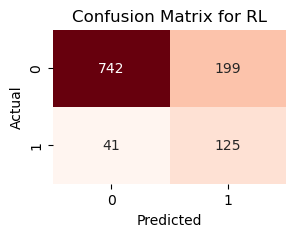

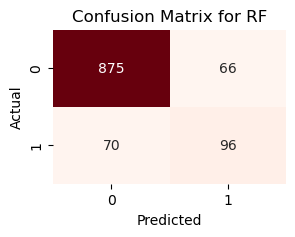

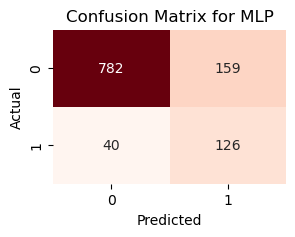

In [159]:
specificity_results = []
sensitivity_results = []

# Calcular especificidad y sensibilidad para cada modelo
for model, prediction in zip(models, predictions):
    # Calcular la matriz de confusión
    tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()
    
    # Print confusion matrix
    cm = confusion_matrix(y_test, prediction)
    plot_confusion_matrix(cm, model)
    
    # Calcular especificidad y sensibilidad
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    
    # Agregar los resultados a las listas
    specificity_results.append(specificity)
    sensitivity_results.append(sensitivity)

# Crear un DataFrame con los resultados de especificidad
df_specificity = pd.DataFrame({'Model': models, 'Specificity': specificity_results})

# Crear un DataFrame con los resultados de sensibilidad
df_sensitivity = pd.DataFrame({'Model': models, 'Sensitivity': sensitivity_results})

In [155]:
print("Especificidad: (no best sellers clasificados correctamente)")
df_specificity

Especificidad: (no best sellers clasificados correctamente)


,Model,Specificity
0,RL,0.788523
1,RF,0.929862
2,MLP,0.831031


In [156]:
print("Sensibilidad: (best sellers clasificados correctamente)")
df_sensitivity

Sensibilidad: (best sellers clasificados correctamente)


,Model,Sensitivity
0,RL,0.753012
1,RF,0.578313
2,MLP,0.759036


**Comparación métricas modelos**

In [157]:
df_results = pd.merge(df_bal_acc, df_specificity)
df_results = pd.merge(df_results, df_sensitivity)
df_results

,Model,Balanced Accuracy,Specificity,Sensitivity
0,RL,0.770767,0.788523,0.753012
1,RF,0.754088,0.929862,0.578313
2,MLP,0.795033,0.831031,0.759036


**Conclusiones**

Similitudes
* Tasa de ciertos balanceada superior al 75%
* Especificidad es la mejor métrica (superior al 78%)
* Sensibilidad es la peor métrica (superior el 57%)

Diferencias
* MLP es superior a los otros dos ligeramente en tasa de ciertos balanceada
* MLP es superior a RF en más de un 15% en sensibilidad
* MLP es ligeramente superior a RL en sensibilidad
* RF es bastante superior a los otros en especificidad (alrededor de 10%) pero con una sensibilidad pésima

Con este análisis consideramos que el mejor modelo es **MLP** porque es superior a los otros en la tasa de aciertos balanceada y en sensibilidad. Aunque RF sea superior en especificidad (métrica complementaria de referencia), su sensibilidad es atroz (prácticamente igual que tirar una moneda) y además es inferior a MLP en la métrica principal (5% menor).

## Análisis por segmentos (géneros literarios)

## Análisis de las variables de cada modelo

In [61]:
import matplotlib.pyplot as plt

Regresión Logística

Para analizar la importancia de las variables estudiamos los coeficientes de la regresión logística. Los coeficientes más grandes (en valor absoluto) indican una mayor influencia en la predicción. Mostramos dos gráficas separando las variables categóricas de las numéricas.

In [97]:
nombres_variables_RL = X_scaled_train[varRL].columns.to_list()

In [105]:
# Filtramos las variables con coeficiente distinto de cero
non_zero_coef_indices = np.where(RL_model.coef_[0] != 0)[0]
non_zero_coef = RL_model.coef_[0][non_zero_coef_indices]
non_zero_feature_names = [nombres_variables_RL[i] for i in non_zero_coef_indices]

In [106]:
nombres_variables_num = ['NumPages', 'Price', 'WordsTitle', 'BookInterest1M', 'Rating20Days', 'PrevBestSellAuthor', 'RedPerc', 'BluePerc']

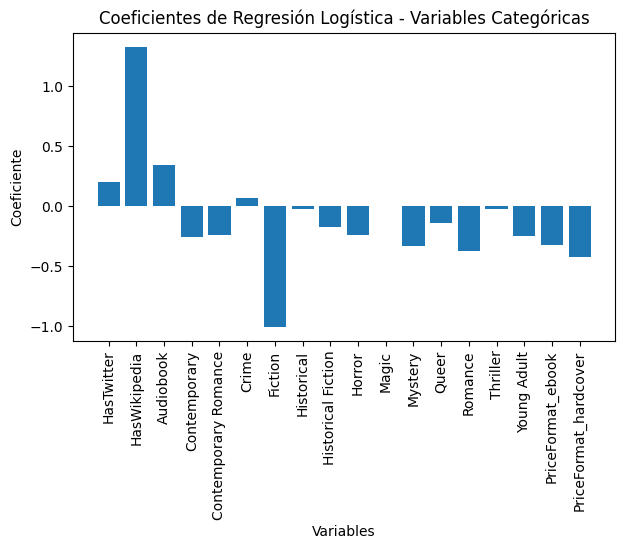

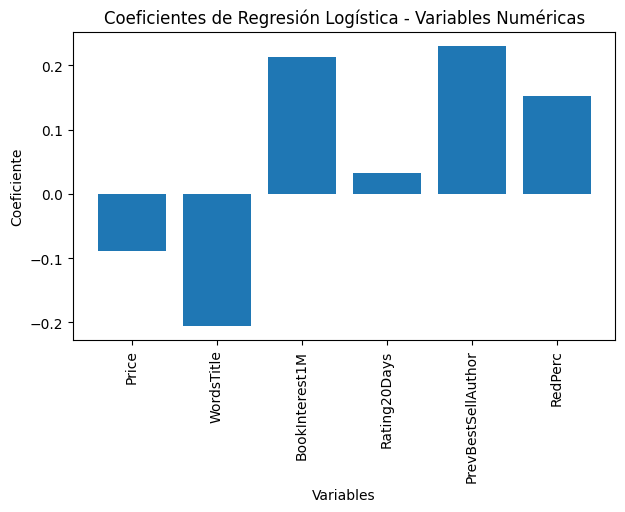

In [107]:
# Variables numéricas
coeficientes_num = []
nombres_num = []

# Resto de variables
nombres_no_num = [nombre for nombre in nombres_variables_RL if nombre not in nombres_variables_num]
coeficientes_no_num = []
nombres_no_num_filt = []

for i, nombre in enumerate(nombres_no_num):
    if nombre in non_zero_feature_names:
        coeficientes_no_num.append(non_zero_coef[non_zero_feature_names.index(nombre)])
        nombres_no_num_filt.append(nombre)

plt.figure(figsize=(7, 4))
plt.bar(range(len(coeficientes_no_num)), coeficientes_no_num)
plt.xticks(range(len(coeficientes_no_num)), nombres_no_num_filt, rotation=90)
plt.title('Coeficientes de Regresión Logística - Variables Categóricas')
plt.xlabel('Variables')
plt.ylabel('Coeficiente')
plt.show()

for i, nombre in enumerate(nombres_variables_num):
    if nombre in non_zero_feature_names:
        coeficientes_num.append(non_zero_coef[non_zero_feature_names.index(nombre)])
        nombres_num.append(nombre)

plt.figure(figsize=(7, 4))
plt.bar(range(len(coeficientes_num)), coeficientes_num)
plt.xticks(range(len(coeficientes_num)), nombres_num, rotation=90)
plt.title('Coeficientes de Regresión Logística - Variables Numéricas')
plt.xlabel('Variables')
plt.ylabel('Coeficiente')
plt.show()


Se observa como algunas variables tienen coeficiente negativo, indicando una relación inversa con la variable respuesta. Wordstitle tiene la correlación negativa más fuerte seguida de la de Price y Fiction.

Random Forest

Para analizar la importancia de las variables utilizaremos el atributo feature_importances_ del modelo entrenado de Random Forest

In [82]:
nombres_variables_RF = X_train.columns.to_list()

['NumPages',
 'SagaNumber',
 'RedPerc',
 'BluePerc',
 'BelongsSaga',
 'Price',
 'WordsTitle',
 'BookInterest1M',
 'Rating20Days',
 'HasTwitter',
 'HasWikipedia',
 'PrevBestSellAuthor',
 '19th Century',
 '20th Century',
 'Abuse',
 'Action',
 'Adoption',
 'Adult',
 'Adult Fiction',
 'Adventure',
 'Africa',
 'African American',
 'African American Romance',
 'African Literature',
 'Aliens',
 'Alternate History',
 'Amateur Sleuth',
 'Amazon',
 'American',
 'American History',
 'Americana',
 'Amish',
 'Angels',
 'Animals',
 'Anthologies',
 'Apocalyptic',
 'Apple',
 'Art',
 'Arthurian',
 'Artificial Intelligence',
 'Asia',
 'Asian Literature',
 'Audiobook',
 'Australia',
 'Autistic Spectrum Disorder',
 'Autobiography',
 'BDSM',
 'Banned Books',
 'Baseball',
 'Basketball',
 'Biography',
 'Biography Memoir',
 'Biology',
 'Boarding School',
 'Book Club',
 'Books About Books',
 'Botswana',
 'Boys Love',
 'British Literature',
 'Buddhism',
 'Buisness',
 'Bulgaria',
 'Bulgarian Literature',
 'Busin

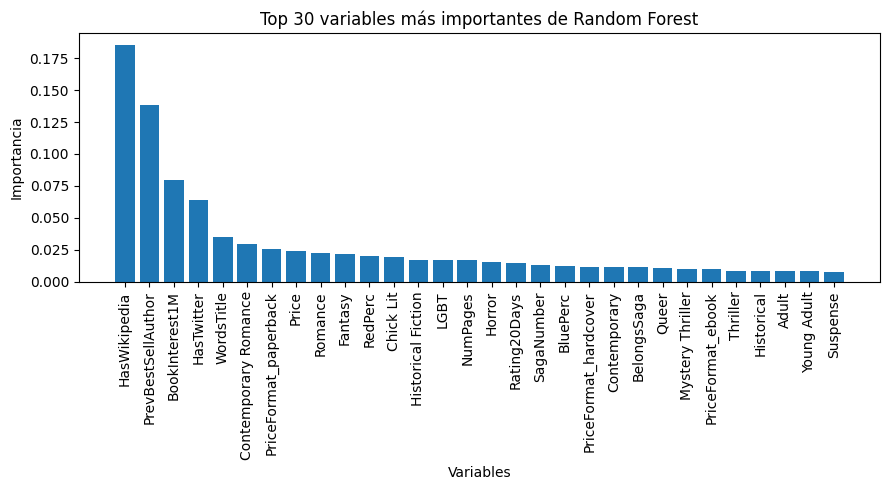

In [77]:
# Obtener índices de las características ordenadas por importancia
sorted_indices = np.argsort(RF_model.feature_importances_)[::-1]

# Seleccionar las 30 características principales
top_indices = sorted_indices[:30]

# Obtener las importancias y nombres de las características correspondientes
top_importances = RF_model.feature_importances_[top_indices]
top_feature_names = [nombres_variables_RF[i] for i in top_indices]

# Graficar las importancias de las características
plt.figure(figsize=(9, 5))
plt.bar(range(len(top_importances)), top_importances)
plt.xticks(range(len(top_importances)), top_feature_names, rotation=90)
plt.title('Top 30 variables más importantes de Random Forest')
plt.xlabel('Variables')
plt.ylabel('Importancia')
plt.tight_layout()
plt.show()


Perceptrón multicapa (MLP)

Para el modelo de MLP, Scikit-learn no proporciona una función integrada para calcular la importancia de las variables como lo hace para modelos basados en árboles (por ejemplo, Random Forest). No existe por tanto ningún atributo de este modelo que nos proporcione directamente una estimación de la importancia de las variables. Además, la interpretación de modelos de redes neuronales puede ser más compleja que la de modelos lineales o basados en árboles debido a su naturaleza no lineal y a la presencia de múltiples capas ocultas.

**Conclusiones**

Similitudes
* Las variables con más importacia de forma general son HasWikipedia, PrevBestSellAuthor, BookInterest1M, HasTwitter y WordsTitle
* Tanto RL como RF presentan la mayoría de variables con coeficiente/métrica igual a 0 o muy cercano a 0. Por tanto se puede decir que ambos modelos seleccionan las variables más relevantes y reducen considerablemente la dimensionalidad

Diferencias
* En RL las variables 'Fiction' y 'AudioBook' toman bastante relevancia, cosa que en RF no